<h2><strong>Air Pollution Prediction</strong></h2>
<h3><strong>Mission</strong></h3>
<p>The mission is to predict accurately pollution levels. In this project, different deep learning models and architectures will be applied to predict pollution levels.</p>
<h3><strong>Dataset Content</strong></h3>
<p>The Air Quality dataset.</p>
<p>This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.</p>
<p>Data dictionary:</p>
<ul>
<li>date: Datetime of the observation. Datetime</li>
<li>pollution: PM2.5 concentration. This is the target. Float</li>
<li>dew: Dew Point. Integer</li>
<li>temp: Temperature. Float</li>
<li>press: Pressure. Float</li>
<li>wnd_dir: Combined wind direction. String</li>
<li>wnd_spd: Cumulated wind speed. Float</li>
<li>snow: Cumulated hours of snow. Integer</li>
<li>rain: Cumulated hours of rain. Integer</li>
</ul>
<h3><strong>Source</strong></h3>
<p>This dataset and the information specified above was obtained in <a href="https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate/data">Kaggle</a></p>


<h3><strong>Problem Statement</strong></h3>
<p>The goal of this project is to predict air pollution levels based on historical meteorological data. The importance of achieving this successfully is using this solution to accurately predict pollution levels and with that predictions take actions to low down pollution levels nearby that location.</p>
<p>This data was collected by the US embassy in Beijing, China and contains historical observations of air pollution and other meteorological variables.</p>
<p>This task is identified as a supervised deep learning problem focused on Time Series Forecasting. Different deep learning models and architectures are going to be applied. This project aims to predict future pollution levels based on historical observations.</p>
<h3><strong>Evaluation</strong></h3>
<p>The following metrics are being considered to evaluate the performance of the models:</p>
<ul>
<li>Mean Squared Error (MSE)</li>
<li>Root Mean Squared Error (RMSE)</li>
<li>Mean Absolute Error (MAE)</li>
</ul>


<h3>Pipeline Summary:</h3>
</ol>
<h3>Data Exploration and Preprocessing-&gt; Modelling -&gt; First experimentation (4 models) -&gt; First evaluation -&gt; Second experimentation (10 different configurations) -&gt; Final Evaluation </h3>


### Libraries and Packages


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model


### Data Pre Processing and EDA


In [10]:
df = pd.read_csv('./LSTM-Multivariate_pollution.csv')

In [11]:
df.shape

(43800, 9)

In [12]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Check for the time range of the dataset


In [13]:
df.date.min() , df.date.max()

('2010-01-02 00:00:00', '2014-12-31 23:00:00')

In [14]:
df['date'] = pd.to_datetime(df['date'])

In [15]:
df.set_index('date', inplace=True)

Drop the "wnd_dir" column because it is categorical


In [16]:
df = df.drop('wnd_dir', axis=1)

Plot the data to identify seasonal behaviour


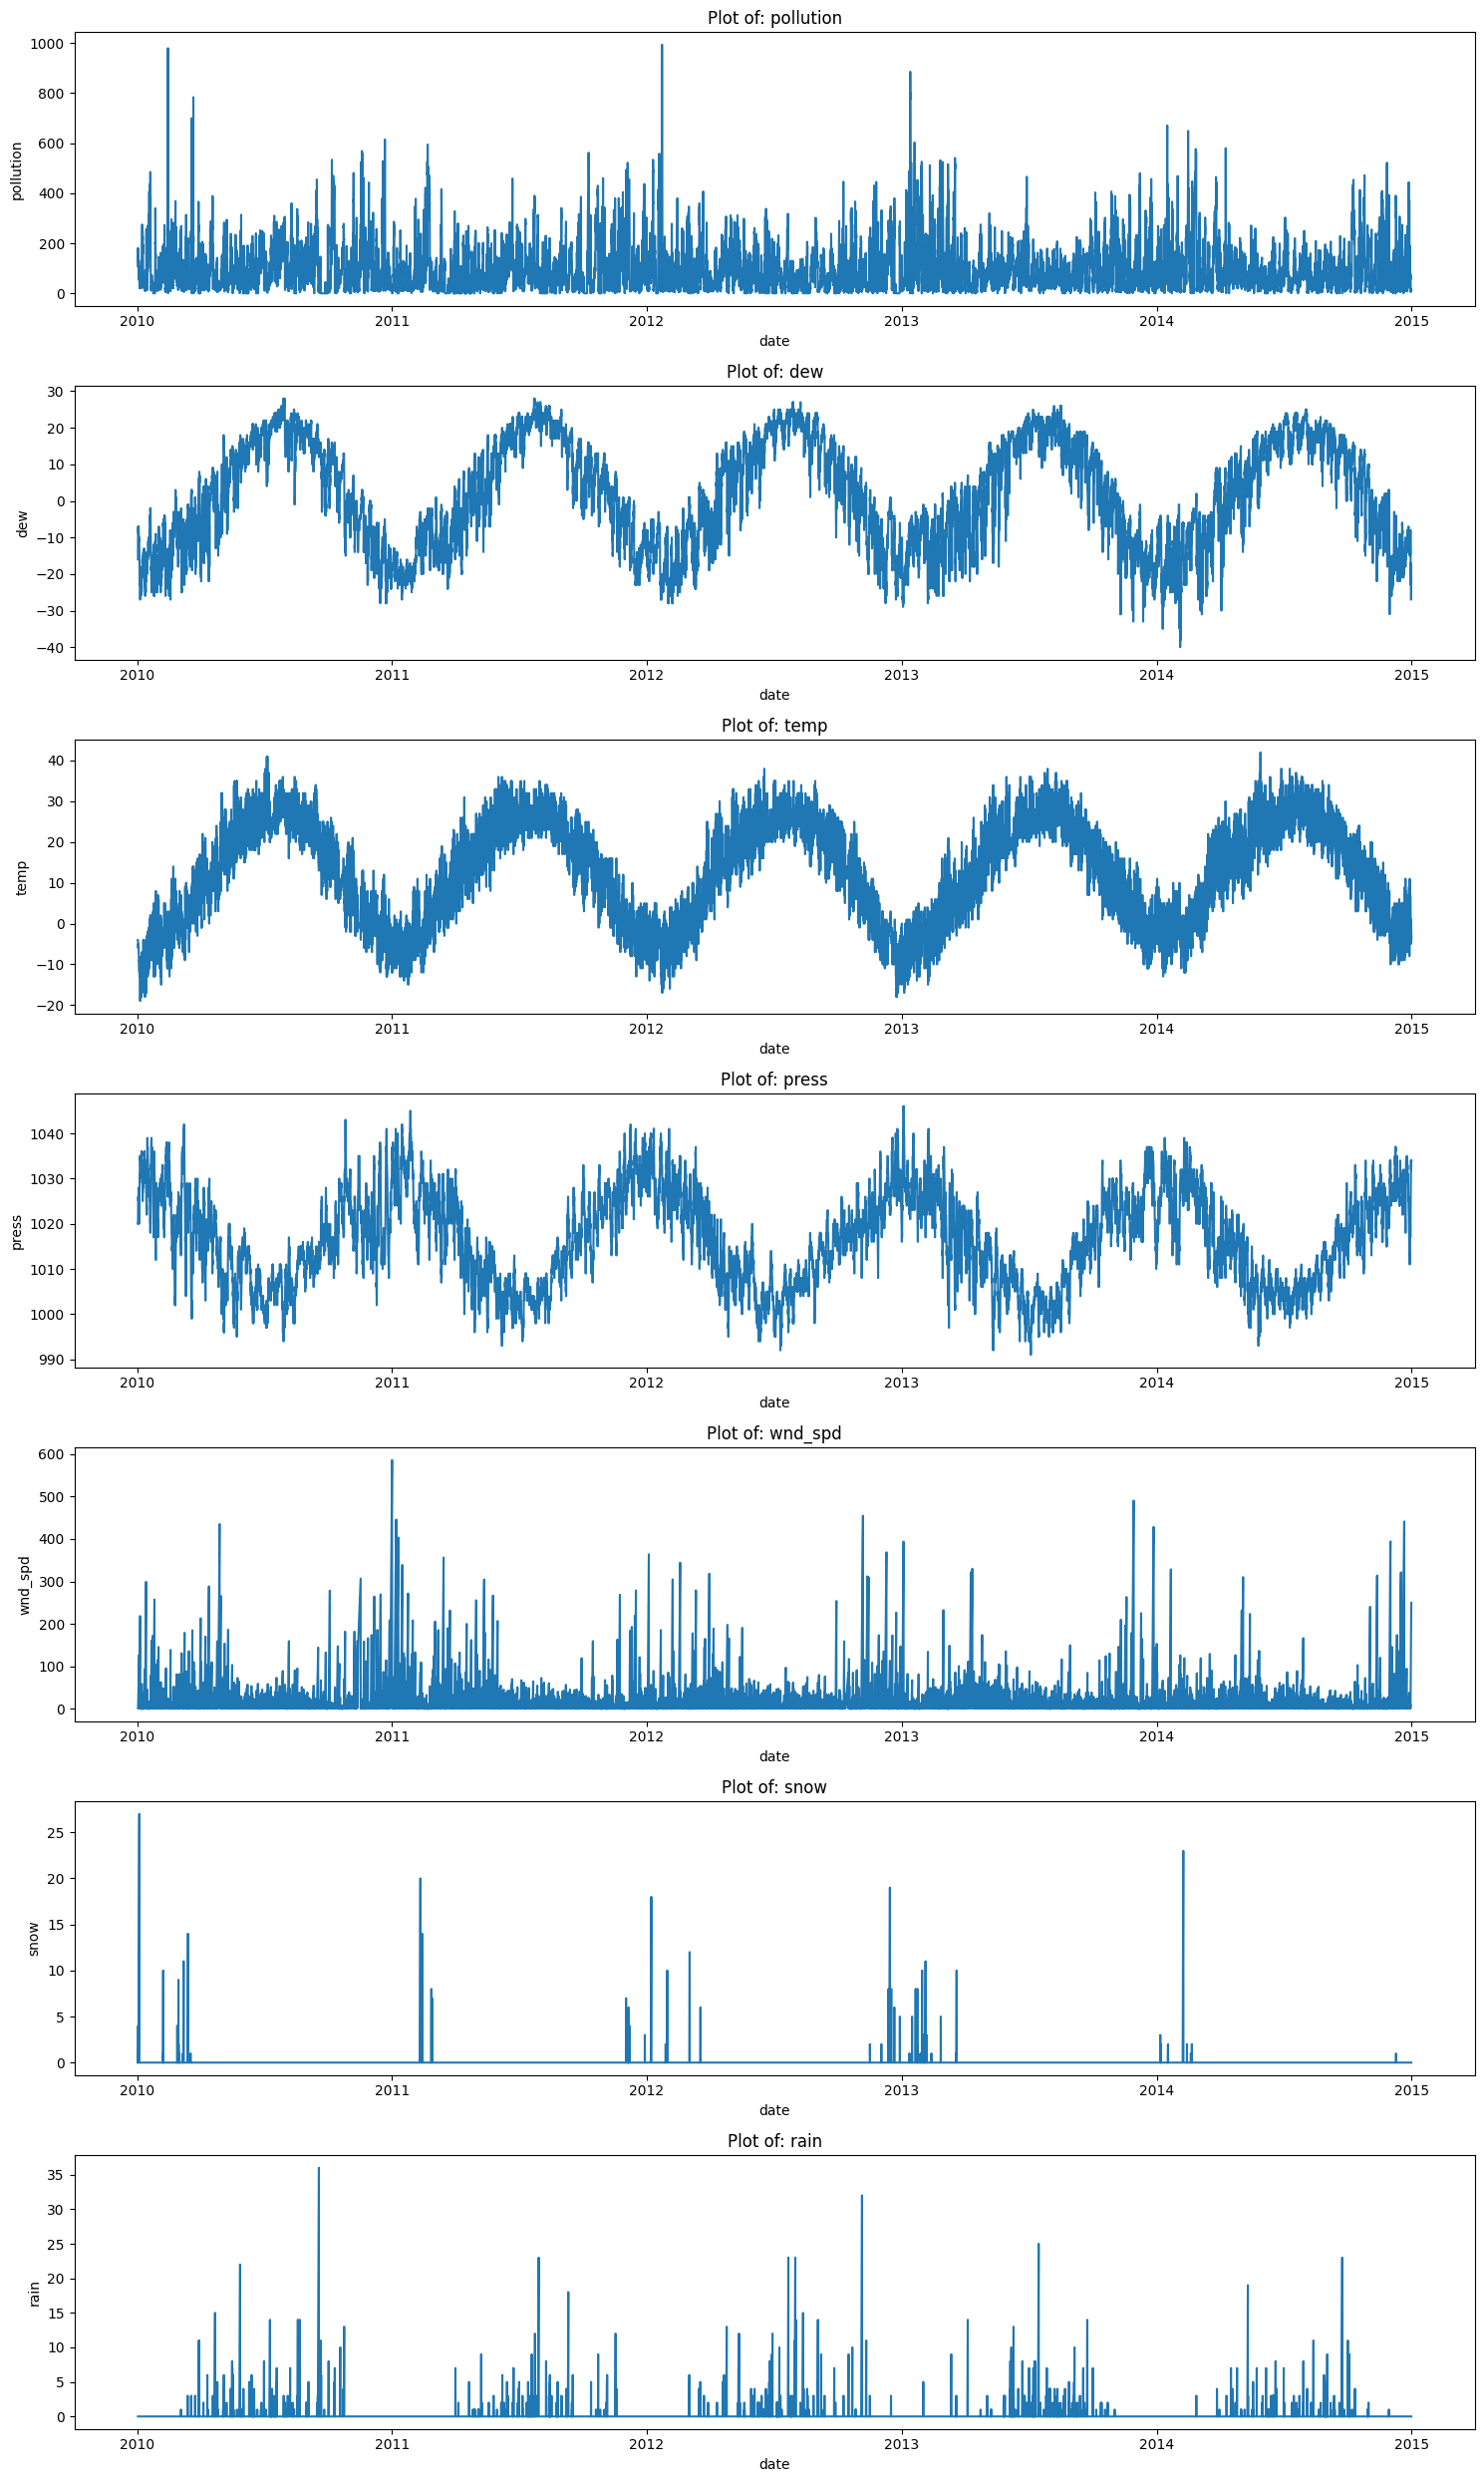

In [17]:
num_cols = 1
num_rows = (len(df.columns.to_list()) + num_cols - 1) // num_cols

plt.figure(figsize=(15, 25))

for i, col in enumerate(df.columns.to_list()):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.lineplot(data=df, x=df.index , y=df[col])
    plt.title(f'Plot of: {col}')

plt.tight_layout()
plt.show()

Set the train, test and validation data. 0.7 for train, 0.15 for test and validation


In [18]:
train_size = 0.7
val_size = 0.15

train_end_idx = int(len(df) * train_size)
val_end_idx = train_end_idx + int(len(df) * val_size)

train_data = df.iloc[:train_end_idx]
val_data = df.iloc[train_end_idx:val_end_idx]
test_data = df.iloc[val_end_idx:]

The data is scalled after splitting the data, because of professor recommendation


In [19]:
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
val_data_scaled = pd.DataFrame(scaler.transform(val_data), columns=val_data.columns, index=val_data.index)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

### Modeling


#### Useful functions


The function "create_sequences" is used to create sequesnces of time series data, using as input the window size, predictors column and target column.
It returns: X (features as sequences) and y (target value)


In [20]:
def create_sequences(data, target_column, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size].values)
        y.append(data.iloc[i + window_size][target_column])
    return np.array(X), np.array(y)

The function "train_and_evaluate" is used to train the model giving X and y (train, test and validation) and some other parameters such as loss function, optimizer, metrics, epochs and batch size. Returns the y_predicted and training history of the model applied


In [21]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                                     model_name, loss, optimizer, metrics, epochs=10, batch_size=32):
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    checkpoint = ModelCheckpoint(f'{model_name}.keras', save_best_only=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint],
        verbose=1
    )

    model.load_weights(f'{model_name}.keras')
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"{model_name} - Test Loss: {test_loss}, Test MAE: {test_mae}")

    y_pred = model.predict(X_test).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse_ = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Single Target: RMSE={rmse:.4f}, MSE={mse_:.4f}, MAE={mae:.4f}")

    return y_pred, history

The function "plot_predictions" takes a model, make predictions and then plot the predicted values vs the real ones. To avoid plotting the whole time series, "start" and "end" parameters are used for plotting a "sample" of the whole time series. It returns a dataframe with predictions and real values.


In [22]:
def plot_predictions(model_path, X_data, y_actual, start=0, end=100, title="Predictions vs Actuals"):

    model = load_model(model_path)
    
    predictions = model.predict(X_data).flatten()
    
    results = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y_actual})
    
    mse_ = mean_squared_error(y_actual,predictions)
    print(f"MSE: {mse_:.4f}" )

    plt.figure(figsize=(12, 6))
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend()
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.show()
    
    return results

### Univariate Models


In [23]:
window_size = 5
X_train1, y_train1 = create_sequences(train_data_scaled[['pollution']], target_column='pollution', window_size=window_size)
X_val1, y_val1 = create_sequences(val_data_scaled[['pollution']], target_column='pollution', window_size=window_size)
X_test1, y_test1 = create_sequences(test_data_scaled[['pollution']], target_column='pollution', window_size=window_size)

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((30654, 5, 1), (30654,), (6565, 5, 1), (6565,), (6566, 5, 1), (6566,))

#### Univariate LSTM with Dense Layers for Single Target Prediction


In [24]:
model_uv_st_lstm = Sequential()
model_uv_st_lstm.add(InputLayer((window_size, 1)))
model_uv_st_lstm.add(LSTM(64))
model_uv_st_lstm.add(Dense(8, 'relu'))
model_uv_st_lstm.add(Dense(1, 'linear'))

model_uv_st_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
y1_pred, history = train_and_evaluate(model=model_uv_st_lstm,
                                                    X_train=X_train1,
                                                    y_train=y_train1,
                                                    X_val= X_val1,
                                                    y_val= y_val1,
                                                    X_test=X_test1,
                                                    y_test=y_test1,
                                                    model_name="model_uv_st_lstm",
                                                    loss=MeanSquaredError(),
                                                    optimizer=Adam(learning_rate=0.0001),
                                                    metrics=[RootMeanSquaredError()],
                                                    epochs=10,
                                                    batch_size=32
                                                    )

Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5415 - root_mean_squared_error: 0.7249 - val_loss: 0.1913 - val_root_mean_squared_error: 0.4374
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1930 - root_mean_squared_error: 0.4388 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1208 - root_mean_squared_error: 0.3474 - val_loss: 0.0913 - val_root_mean_squared_error: 0.3022
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1093 - root_mean_squared_error: 0.3301 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2896
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1006 - root_mean_squared_error: 0.3170 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0919 - root_mean_squared_error: 0.3029 - val_loss: 0.0742 - val_root_mean_squared_error: 0.2724
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
MSE: 0.0547


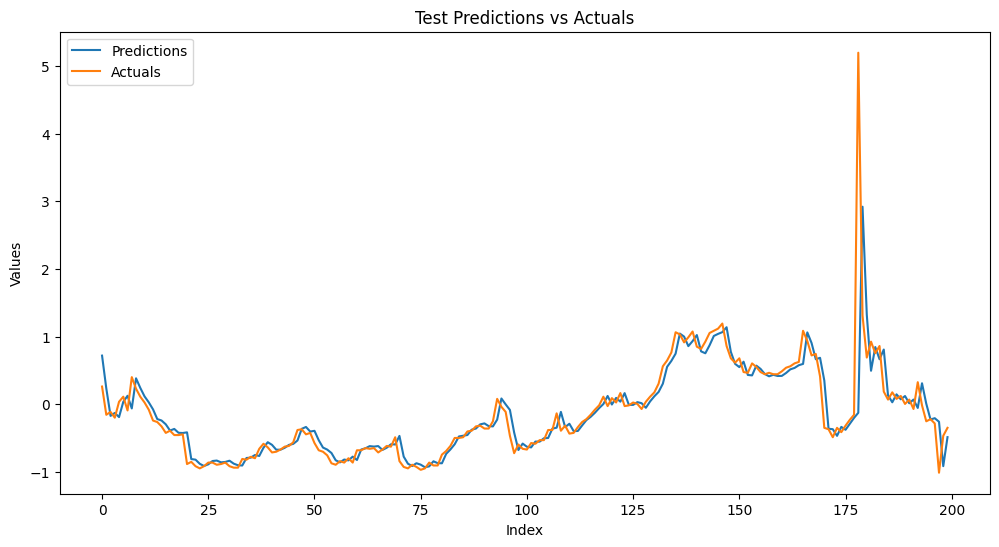

In [26]:
test_results_1 = plot_predictions(
    model_path='model_uv_st_lstm.keras', 
    X_data=X_test1, 
    y_actual=y_test1, 
    start=0, 
    end=200, 
    title="Test Predictions vs Actuals"
)

#### Univariate 1D Convolutional Neural Network (Conv1D) for Single Target Prediction


In [27]:
model_uv_st_conv1d = Sequential()
model_uv_st_conv1d.add(InputLayer((5, 1)))
model_uv_st_conv1d.add(Conv1D(64, kernel_size=2))
model_uv_st_conv1d.add(Flatten())
model_uv_st_conv1d.add(Dense(8, 'relu'))
model_uv_st_conv1d.add(Dense(1, 'linear'))

model_uv_st_conv1d.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
y1_pred_2, history_2 = train_and_evaluate(model=model_uv_st_conv1d,
                                                    X_train=X_train1,
                                                    y_train=y_train1,
                                                    X_val= X_val1,
                                                    y_val= y_val1,
                                                    X_test=X_test1,
                                                    y_test=y_test1,
                                                    model_name="model_uv_st_conv1d",
                                                    loss=MeanSquaredError(),
                                                    optimizer=Adam(learning_rate=0.0001),
                                                    metrics=[RootMeanSquaredError()],
                                                    epochs=10,
                                                    batch_size=32
                                                    )

Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - loss: 0.2381 - root_mean_squared_error: 0.4823 - val_loss: 0.0888 - val_root_mean_squared_error: 0.2980
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 0.1065 - root_mean_squared_error: 0.3259 - val_loss: 0.0755 - val_root_mean_squared_error: 0.2748
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.0883 - root_mean_squared_error: 0.2970 - val_loss: 0.0724 - val_root_mean_squared_error: 0.2690
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - loss: 0.0873 - root_mean_squared_error: 0.2951 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2675
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - loss: 0.0974 - root_mean_squared_error: 0.3108 - val_loss: 0.0695 - val_root_mean_squared_error: 0.2637
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - loss: 0.1128 - root_mean_squared_error: 0.3339 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2602
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
MSE: 0.0576


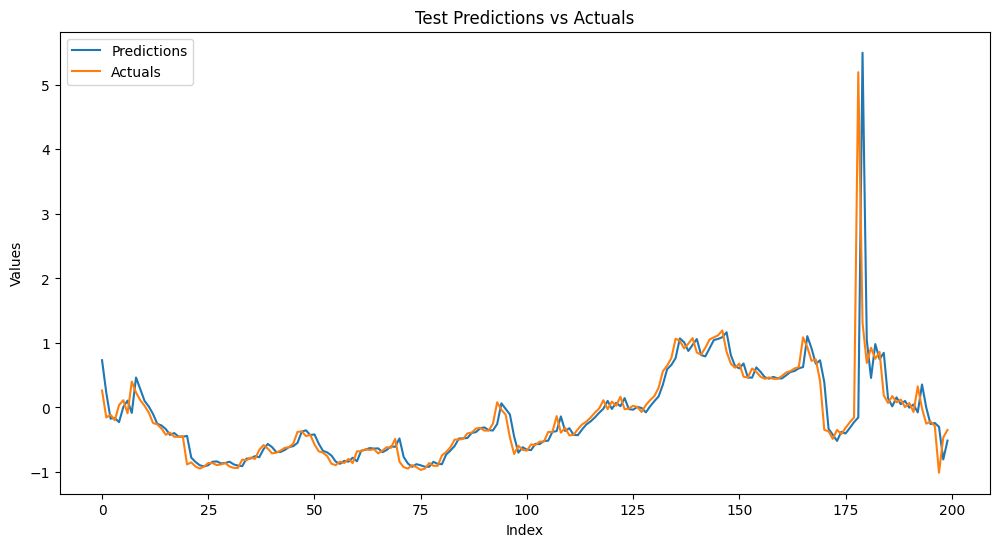

In [29]:
test_results_2 = plot_predictions(
    model_path='model_uv_st_conv1d.keras', 
    X_data=X_test1, 
    y_actual=y_test1, 
    start=0, 
    end=200, 
    title="Test Predictions vs Actuals"
)

#### Univariate GRU with Dense Layers for Single Target Prediction


In [30]:
model_uv_st_gru = Sequential()
model_uv_st_gru.add(InputLayer((5, 1)))
model_uv_st_gru.add(GRU(64))
model_uv_st_gru.add(Dense(8, 'relu'))
model_uv_st_gru.add(Dense(1, 'linear'))
model_uv_st_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
y1_pred_3, history_3 = train_and_evaluate(model=model_uv_st_gru,
                                                    X_train=X_train1,
                                                    y_train=y_train1,
                                                    X_val= X_val1,
                                                    y_val= y_val1,
                                                    X_test=X_test1,
                                                    y_test=y_test1,
                                                    model_name="model_uv_st_gru",
                                                    loss=MeanSquaredError(),
                                                    optimizer=Adam(learning_rate=0.0001),
                                                    metrics=[RootMeanSquaredError()],
                                                    epochs=10,
                                                    batch_size=32
                                                    )

Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4334 - root_mean_squared_error: 0.6453 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3196
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0800 - val_root_mean_squared_error: 0.2829
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1025 - root_mean_squared_error: 0.3193 - val_loss: 0.0758 - val_root_mean_squared_error: 0.2753
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0990 - root_mean_squared_error: 0.3143 - val_loss: 0.0729 - val_root_mean_squared_error: 0.2699
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0925 - root_mean_squared_error: 0.3040 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2692
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0878 - root_mean_squared_error: 0.2957 - val_loss: 0.0704 - val_root_mean_squared_error: 0.2654
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step 

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
MSE: 0.0544


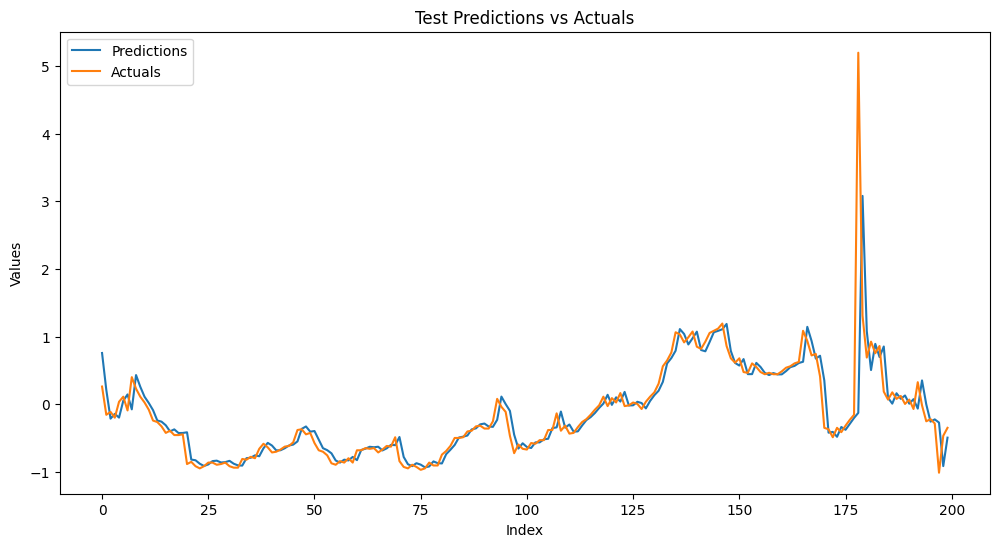

In [32]:
test_results_3 = plot_predictions(
    model_path='model_uv_st_gru.keras', 
    X_data=X_test1, 
    y_actual=y_test1, 
    start=0, 
    end=200, 
    title="Test Predictions vs Actuals"
)

### Multi Variate Models


"data_columns" is the list that contains all the columns that will be considered as predictors


In [33]:
data_columns = ['pollution','dew','temp','press']

In [34]:
window_size = 6
X_multi_train , y_multi_train = create_sequences(train_data_scaled[data_columns], target_column='pollution', window_size=window_size)
X_multi_val , y_multi_val = create_sequences(val_data_scaled[data_columns], target_column='pollution', window_size=window_size)
X_multi_test , y_multi_test = create_sequences(test_data_scaled[data_columns], target_column='pollution', window_size=window_size)

X_multi_train.shape, y_multi_train.shape, X_multi_val.shape, y_multi_val.shape, X_multi_test.shape, y_multi_test.shape

((30653, 6, 4), (30653,), (6564, 6, 4), (6564,), (6565, 6, 4), (6565,))

#### Multivariate LSTM with Dense Layers for Single Target Prediction


In [35]:
model_mv_st_lstm = Sequential()
model_mv_st_lstm.add(InputLayer((window_size, len(data_columns))))
model_mv_st_lstm.add(LSTM(64))
model_mv_st_lstm.add(Dense(8, 'relu'))
model_mv_st_lstm.add(Dense(1, 'linear'))

model_mv_st_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
y1_pred_4, history_4 = train_and_evaluate(model=model_mv_st_lstm,
                                                    X_train=X_multi_train,
                                                    y_train=y_multi_train,
                                                    X_val= X_multi_val,
                                                    y_val= y_multi_val,
                                                    X_test=X_multi_test,
                                                    y_test=y_multi_test,
                                                    model_name="model_mv_st_lstm",
                                                    loss=MeanSquaredError(),
                                                    optimizer=Adam(learning_rate=0.0001),
                                                    metrics=[RootMeanSquaredError()],
                                                    epochs=10,
                                                    batch_size=32
                                                    )

Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4706 - root_mean_squared_error: 0.6805 - val_loss: 0.1646 - val_root_mean_squared_error: 0.4057
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1573 - root_mean_squared_error: 0.3963 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3242
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1133 - root_mean_squared_error: 0.3363 - val_loss: 0.0877 - val_root_mean_squared_error: 0.2961
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0974 - root_mean_squared_error: 0.3119 - val_loss: 0.0783 - val_root_mean_squared_error: 0.2797
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0903 - root_mean_squared_error: 0.3004 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2692
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0948 - root_mean_squared_error: 0.3073 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2632
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step 

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
MSE: 0.0520


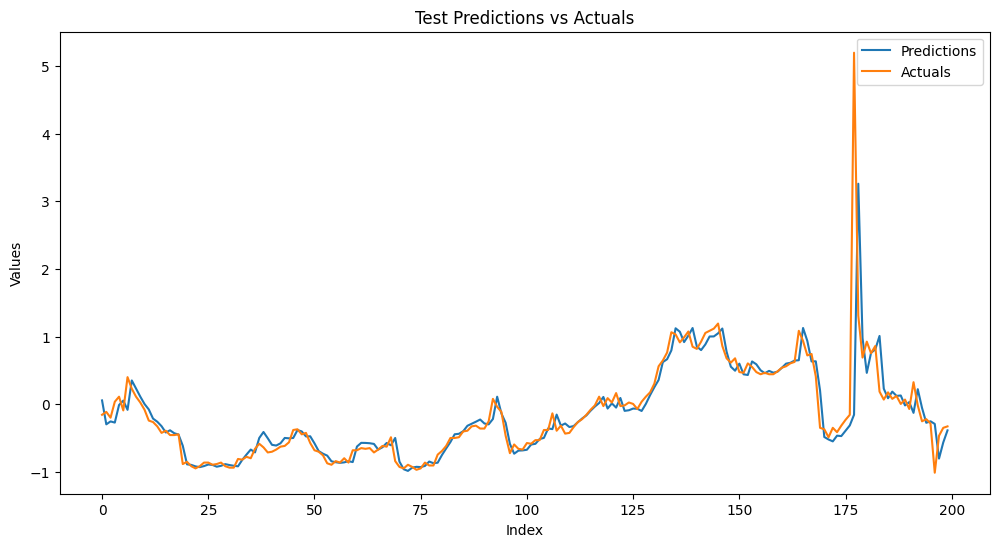

In [37]:
test_results_4 = plot_predictions(
    model_path='model_mv_st_lstm.keras', 
    X_data=X_multi_test, 
    y_actual=y_multi_test, 
    start=0, 
    end=200, 
    title="Test Predictions vs Actuals"
)

### First Evaluation


In [39]:
results_df = pd.DataFrame({
    'Model': ['UV-LSTM', 'UV-Conv1D', 'UV-GRU', 'MV-LSTM'],
    'MSE': [mean_squared_error(y_test1, y1_pred), mean_squared_error(y_test1, y1_pred_2), mean_squared_error(y_test1, y1_pred_3), mean_squared_error(y_multi_test, y1_pred_4)],
    'RMSE': [np.sqrt(mean_squared_error(y_test1, y1_pred)), np.sqrt(mean_squared_error(y_test1, y1_pred_2)), np.sqrt(mean_squared_error(y_test1, y1_pred_3)), np.sqrt(mean_squared_error(y_multi_test, y1_pred_4))],
    'MAE': [mean_absolute_error(y_test1, y1_pred), mean_absolute_error(y_test1, y1_pred_2), mean_absolute_error(y_test1, y1_pred_3), mean_absolute_error(y_multi_test, y1_pred_4)]
})

results_df

,Model,MSE,RMSE,MAE
0,UV-LSTM,0.054721,0.233925,0.124048
1,UV-Conv1D,0.057570,0.239937,0.123908
2,UV-GRU,0.054375,0.233185,0.121315
3,MV-LSTM,0.051955,0.227937,0.119029


<p>The first experiments of this project were using four different architectures. For the univariate models the &ldquo;pollution&rdquo; variable used as X variable. For the multivariate model the columns: [&ldquo;pollution&rdquo;, &ldquo;dew&rdquo;, &ldquo;temp&rdquo;, &ldquo;press&rdquo;] were used as X.</p>
<p>The following models are:</p>
<ul>
<li>Univariate LSTM:
<ul>
<li>Input layer (5,1)</li>
<li>Window size: 5</li>
<li>LSTM (64)</li>
<li>Dense (8, &ldquo;relu&rdquo;)</li>
<li>Dense (1,&rdquo; linear&rdquo;)</li>
<li>Adam optimizer</li>
<li>Learning rate: 0.0001</li>
<li>Epochs: 10</li>
<li>Batch size: 32</li>
</ul>
</li>
<li>Univariate Conv 1D:
<ul>
<li>Input layer (5,1)</li>
<li>Window size: 5</li>
<li>Conv 1D (64)</li>
<li>Kernel size: 2</li>
<li>Flatten Layer</li>
<li>Dense (8, &ldquo;relu&rdquo;)</li>
<li>Dense (1,&rdquo; linear&rdquo;)</li>
<li>Adam optimizer</li>
<li>Learning rate: 0.0001</li>
<li>Epochs: 10</li>
<li>Batch size: 32</li>
</ul>
</li>
<li>Univariate GRU:
<ul>
<li>Input layer (5,1)</li>
<li>Window size: 5</li>
<li>GRU (64)</li>
<li>Dense (8, &ldquo;relu&rdquo;)</li>
<li>Dense (1,&rdquo; linear&rdquo;)</li>
<li>Adam optimizer</li>
<li>Learning rate: 0.0001</li>
<li>Epochs: 10</li>
<li>Batch size: 32</li>
</ul>
</li>
<li>Multivariate LSTM:
<ul>
<li>Input layer (6,4)</li>
<li>Window size: 6</li>
<li>LSTM (64)</li>
<li>Dense (8, &ldquo;relu&rdquo;)</li>
<li>Dense (1,&rdquo; linear&rdquo;)</li>
<li>Adam optimizer</li>
<li>Learning rate: 0.0001</li>
<li>Epochs: 10</li>
<li>Batch size: 32</li>
</ul>
</li>
</ul>
<p>After running these 4 configurations and having a table of metrics for each model, the Multivariate LSTM model is the winner because it has better performance metrics. The metrics like MSE and RMSE tell that this winner mode produce more accurate predictions. Also, a lower MAE comparing to the others tells that on average its predictions are closer to the actual values. The Multivariate LSTM models, uses more columns as predictors, this can be a key action, because the neural network can identify multivariate relationships between that features.</p>


### Experimentation and Final Evaluation


<p>List of changes for each configuration:</p>
<ol>
<li>Base model (described above)</li>
<li>Add more neurons and epochs:
<ol style="list-style-type: lower-alpha;">
<li>LSTM (128)</li>
<li>Learning rate: 0.001</li>
<li>Epochs: 50</li>
</ol>
</li>
<li>Add more LSTM layers:
<ol style="list-style-type: lower-alpha;">
<li>LSTM (64) (with return sequences)</li>
<li>LSTM (64)</li>
<li>Learning rate: 0.001</li>
<li>Epochs:50</li>
</ol>
</li>
<li>Add dropout:
<ol style="list-style-type: lower-alpha;">
<li>LSTM (64, dropout=0.3)</li>
</ol>
</li>
<li>Use of Tanh in first Dense layer:
<ol style="list-style-type: lower-alpha;">
<li>Dense (16, activation=&rdquo;tanh&rdquo;)</li>
</ol>
</li>
<li>Change to RMSprop Optimizer and decrease learning rate:
<ol style="list-style-type: lower-alpha;">
<li>Learning rate: 0.0005</li>
<li>Optimizer: RMSprop</li>
</ol>
</li>
<li>Add LSTM layers with dropout and return sequencies
<ol style="list-style-type: lower-alpha;">
<li>LSTM (128, dropout=0.2) with return sequences</li>
<li>LSTM (64, dropout=0.2)</li>
</ol>
</li>
<li>Reduced batch size:
<ol style="list-style-type: lower-alpha;">
<li>batch_size: 16</li>
</ol>
</li>
<li>Reduce LSTM neurons and epochs:
<ol style="list-style-type: lower-alpha;">
<li>LSTM (32)</li>
<li>Epochs: 20</li>
</ol>
</li>
<li>Simple model (remove the intermediate dense layer)</li>
</ol>
<p>After this experimentation step, the metrics were stored in a dataframe:</p>
<table width="455">
<tbody>
<tr>
<td width="235">
<p><strong>Configuration</strong></p>
</td>
<td width="73">
<p><strong>MSE</strong></p>
</td>
<td width="73">
<p><strong>RMSE</strong></p>
</td>
<td width="73">
<p><strong>MAE</strong></p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 1: Base</strong></p>
</td>
<td width="73">
<p>0.052635</p>
</td>
<td width="73">
<p>0.229423</p>
</td>
<td width="73">
<p>0.121725</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 2: More Neurons</strong></p>
</td>
<td width="73">
<p>0.056851</p>
</td>
<td width="73">
<p>0.238435</p>
</td>
<td width="73">
<p>0.124782</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 3: More LSTM Layers</strong></p>
</td>
<td width="73">
<p>0.057696</p>
</td>
<td width="73">
<p>0.2402</p>
</td>
<td width="73">
<p>0.125617</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 4: LSTM + Dropout</strong></p>
</td>
<td width="73">
<p>0.109195</p>
</td>
<td width="73">
<p>0.330446</p>
</td>
<td width="73">
<p>0.239544</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 5: Tanh in Dense</strong></p>
</td>
<td width="73">
<p>0.054348</p>
</td>
<td width="73">
<p>0.233127</p>
</td>
<td width="73">
<p>0.121705</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 6: RMSprop Optimizer</strong></p>
</td>
<td width="73">
<p><strong>0.051804</strong></p>
</td>
<td width="73">
<p><strong>0.227604</strong></p>
</td>
<td width="73">
<p>0.12243</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 7: Stacked LSTM + Dropout</strong></p>
</td>
<td width="73">
<p>0.079525</p>
</td>
<td width="73">
<p>0.282001</p>
</td>
<td width="73">
<p>0.19135</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 8: Reduced Batch Size</strong></p>
</td>
<td width="73">
<p>0.058643</p>
</td>
<td width="73">
<p>0.242162</p>
</td>
<td width="73">
<p>0.122595</p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 9: Fewer Neurons + Epochs</strong></p>
</td>
<td width="73">
<p>0.053241</p>
</td>
<td width="73">
<p>0.23074</p>
</td>
<td width="73">
<p><strong>0.127688</strong></p>
</td>
</tr>
<tr>
<td width="235">
<p><strong>Config 10: Simplified Model</strong></p>
</td>
<td width="73">
<p>0.059997</p>
</td>
<td width="73">
<p>0.244943</p>
</td>
<td width="73">
<p>0.129294&nbsp;</p>
</td>
</tr>
</tbody>
</table>
<p>In the end, configuration number 6 has the best metrics overall. Changing the optimizer had a great impact on the performance. This is a key insight, maybe for this business problem, changing the optimizer from Adam to RMSprop is more convenient, also decreasing a bit the learning rate. In some configurations, the addition of more neurons or more layers did not show any noticeable improvement. The usage of dropout was not useful, because it did not show any upgrade on the metrics.</p>
<p><strong>CONCLUSIONS AND RECOMMENDATIONS</strong></p>
<ul>
<li>For the 10 configurations shown, it seems that a simpler model works better on this data.</li>
<li>Adding more neurons or layers (adding complexity to the model) does not translate into better metrics performance.</li>
<li>Changing to RMSprop optimizer had the best impact in the model one possible recommendation is to use another optimizer.</li>
<li>Try adding more predictive features to enhance the model performance. Features like &ldquo;wnd_spd&rdquo;, &ldquo;snow&rdquo; and &ldquo;rain&rdquo; were not used.</li>
<li>Try to create more features such as: day_sin, day_cosine, year_sin, year_cosine.</li>
<li>Try to use machine learning models. It looks like simpler models work better on this data.</li>
</ul>
